In [1]:
import itertools
import datetime as dt

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Noto Sans CJK JP'
import seaborn as sns
import tqdm
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from utils.scaler import STMatrixStandardScaler
from utils.helper import format_stmatrix, train_test_split, fix_seed
from dataset import STDataset
from trainer import Trainer
from logger import Logger
import config

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

## 前処理してデータセットを作成
- 渋滞量 -> フラグに変換
- 方向 -> 0/1に変換
    - 上り: 0, 下り: 1
- 四半期を数値化
- 使用しないカラムを落とす
    - 天気 + `index`, `data`, `road_code`, `jam_type`
- 速度の欠損を埋める
- OCC -> [0, 1]に変換
- 型変換
    - float64 -> float32
    - 区間の名前, コード, 県コード, 0/1系, カレンダーデータをcategoryデータに
    - degreeをint32

In [ ]:
# 道路名
# TARGET_ROAD='tateyama'
TARGET_ROAD='kannetsu'

# 交通量
PROCESSED_DATA_DIR = '../Input_processed_data'
TRAFFIC_DIR = f'{PROCESSED_DATA_DIR}/traffic'
TRAFFIC_CSV = f'{TRAFFIC_DIR}/{TARGET_ROAD}_20220621all-merged_filled_15min.csv'

In [ ]:
col_types = {'start_code': str, 'end_code': str, 'road_code': str, 'jam_type': str,}

df = pd.read_csv(TRAFFIC_CSV, parse_dates=True, index_col='datetime', dtype=col_types).reset_index()

In [ ]:
def linear_interpolate(df, col):
    '''
    dfのcolカラム内の欠損を区間ごとに線形補間する
    '''
    f = lambda g: g.interpolate(method='linear', axis=0)
    
    df.sort_values('datetime', inplace=True)
    df[col] = df.groupby(['start_code', 'end_code'])[col].apply(f)
    return df


def preprocess(df):
    # 「年」情報を入れる
    df['year'] = df['datetime'].dt.year
    # 渋滞フラグ 0/1
    df['jam_quantity'] = np.where(df['speed'] < 40, 1, 0)
    # 方向を数値化
    direction_map = {'上り': 0, '下り': 1}
    df['direction'] = df['direction'].map(direction_map)
    # 四半期を数値化
    df['quarter'] = df['quarter'].str[-1]
    
    # object型のカラム, いらないカラムを落とす
    drop_cols = [
        'index', 'date', 'road_code', 'pressure', 'rainfall', 
        'temperature', 'humidity', 'wind_speed', 'daylight_hours', 
        'snowfall', 'deepest_snowfall', 'weather_description', 'jam_type'
    ]
    df.drop(drop_cols, axis=1, inplace=True)
    
    # 速度の欠損を埋める
    df = linear_interpolate(df, 'speed')
    # OCCを[0,1]に変換
    df['OCC'] = df['OCC'] / 100.0
    
    # 型変換
    f64_cols = df.select_dtypes(include=[np.float64]).columns
    df.loc[:, f64_cols] = df.loc[:, f64_cols].astype(np.float32)
    i64_cols = df.select_dtypes(include=[int]).columns
    df.loc[:, i64_cols] = df.loc[:, i64_cols].astype(np.int32)
    
    type_map = {
        'start_name': 'category',
        'end_name': 'category',
        'start_code': 'category',
        'end_code': 'category',
        'start_pref_code': 'category',
        'end_pref_code': 'category',
        'direction': 'category',
        'month': 'category',
        'day': 'category',
        'dayofweek': 'category',
        'is_holiday': 'category',
        'hour': 'category',
        'quarter': 'category',
        'jam_quantity': 'category',
        'start_degree': np.int32,
        'end_degree': np.int32,
        'degree_sum': np.int32,
    }
    df = df.astype(type_map)
    
    return df

In [ ]:
def create_dataset(df, start_date, end_date, pkl_name):
    tmp = df.loc[(df['datetime'] >= pd.Timestamp(start_date)) & (df['datetime'] < pd.Timestamp(end_date))]
    # tmp.reset_index(drop=True, inplace=True)
    
    tmp = preprocess(tmp.copy())
    tmp.reset_index(drop=True, inplace=True)
    
    tmp.to_pickle(pkl_name)

# whole dataset
start_date = '2021/4/2'
end_date = '2022/6/1'
pkl_name = './datasets/kannetsu_210402-220531.pkl'

create_dataset(df, start_date, end_date, pkl_name)

# mini dataset
start_date = '2021/4/2'
end_date = '2021/6/1'
pkl_name = './datasets/kannetsu_210402-210531.pkl'

create_dataset(df, start_date, end_date, pkl_name)

## データセットを読み込む

In [69]:
# mini
df_test = pd.read_pickle('./datasets/kannetsu_210402-210531.pkl')
# whole
df_all = pd.read_pickle('./datasets/kannetsu_210402-220531.pkl')

In [70]:
dt_table = pd.read_pickle('./datasets/datetime_table.pkl')
sec_table = pd.read_pickle('./datasets/section_table.pkl')

In [71]:
df_test.head(3)

,datetime,start_name,end_name,start_code,end_code,start_pref_code,end_pref_code,start_lat,end_lat,start_lng,...,search_unspec_10d,minute_quarter,allCars,jam_quantity,search_15min,OCC,speed,year,datetime_id,section_id
0,2021-04-02,所沢,大泉ＪＣＴ,1800006,1110210,11,13,35.806149,35.755821,139.535507,...,2156.0,0,223.0,0,8.0,0.03,86.421524,2021,8,31
1,2021-04-02,越後川口,堀之内,1800171,1800161,15,15,37.264629,37.251381,138.839630,...,798.0,0,17.0,0,0.0,0.00,89.411766,2021,8,2
2,2021-04-02,堀之内,小出,1800161,1800156,15,15,37.251381,37.213329,138.928635,...,786.0,0,14.0,0,1.0,0.00,90.285713,2021,8,3


### 時間, 区間にembedding用のIDを割り振る

In [ ]:
# 時間情報を管理するためのテーブルを作成 (month x hour x dayofweeks x is_holidays)
# months = range(1, 12+1)
# hours = range(24)
# dayofweeks = range(1, 7+1)
# is_holidays = (0, 1)

# dt_table = pd.DataFrame(itertools.product(months, hours, dayofweeks, is_holidays), columns=['month', 'hour', 'dayofweek', 'is_holiday'], dtype='category')
# dt_table = dt_table.query('dayofweek not in (6, 7) | is_holiday != 0').reset_index(drop=True)
# dt_table = dt_table.reset_index().set_index(['month', 'hour', 'dayofweek', 'is_holiday']).astype('category')

# dt_table.to_pickle('./datasets/datetime_table.pkl')

# dt_table = pd.read_pickle('./datasets/datetime_table.pkl')

In [ ]:
# 時間情報を管理するためのテーブルを作成 (hour x dayofweeks x is_holidays)
# hours = range(24)
# dayofweeks = range(1, 7+1)
# is_holidays = (0, 1)

# dt_table = pd.DataFrame(itertools.product(hours, dayofweeks, is_holidays), columns=['hour', 'dayofweek', 'is_holiday'], dtype='category')
# dt_table = dt_table.query('dayofweek not in (6, 7) | is_holiday != 0').reset_index(drop=True)
# dt_table = dt_table.reset_index().set_index(['hour', 'dayofweek', 'is_holiday']).astype('category')

# dt_table.to_pickle('./datasets/mini_datetime_table.pkl')

# dt_table = pd.read_pickle('./datasets/mini_datetime_table.pkl')

In [ ]:
# 区間情報を管理するためのテーブルを作成
# sec_table = df_test[['start_name', 'end_name', 'direction', 'KP']].drop_duplicates()
# 区間順にソート
# sort_f = lambda g: g.sort_values('KP', ascending=(g.name == 1))
# sec_table = sec_table.groupby('direction').apply(sort_f).reset_index(drop=True)

# sec_table.to_pickle('./datasets/section_table.pkl')
# sec_table.head(3)

# sec_table = pd.read_pickle('./datasets/section_table.pkl')

In [65]:
def datetime2id(df, dt_table):
    time_col = ['hour', 'dayofweek', 'is_holiday']
    f = lambda g: g.assign(datetime_id=dt_table.loc[g.name, 'index'])
    df = df.groupby(time_col).apply(f)
    df['datetime_id'] = df['datetime_id'].astype('category')
    return df


def section2id(df, sec_table):
    f = lambda g: g.assign(section_id=sec_table.query(f'start_name == "{g.name[0]}" & end_name == "{g.name[1]}"').index.item())
    df = df.groupby(['start_name', 'end_name']).apply(f)
    df['section_id'] = df['section_id'].astype('category')
    return df


def identify(df, dt_table, sec_table):
    df = datetime2id(df, dt_table)
    df = section2id(df, sec_table)
    return df

In [66]:
df_test = identify(df_test, dt_table, sec_table)
df_test.to_pickle('./datasets/kannetsu_210402-210531.pkl')

df_all = identify(df_all, dt_table, sec_table)
df_all.to_pickle('./datasets/kannetsu_210402-220531.pkl')

## Spatial Temporal Matrixに整形
- 区間数 x 時系列数 の行列
- 実際は 区間数 x 時系列数 x 特徴量数 のテンソル

In [106]:
df_test_tr = pd.read_pickle('./datasets/kannetsu_210402-210519.pkl')
df_test_va = pd.read_pickle('./datasets/kannetsu_210520-210531.pkl')

df_all_tr = pd.read_pickle('./datasets/kannetsu_210402-220228.pkl')
df_all_va = pd.read_pickle('./datasets/kannetsu_210402-210519.pkl')

dt_table = pd.read_pickle('./datasets/datetime_table.pkl')
sec_table = pd.read_pickle('./datasets/section_table.pkl')

In [108]:
# 特徴量の元になる列
# time_col = ['month', 'hour', 'dayofweek', 'is_holiday']
# section_col = ['direction', 'lane_count', 'KP']
time_col = ['datetime_id']
section_col = ['section_id']
search_col = ['search_15min', 'search_unspec_1d']
traffic_col = ['allCars']

feature_col = time_col + section_col + search_col + traffic_col
# feature_col = time_col + section_col + traffic_col
# feature_col = search_col + traffic_col

# 予測対象
target_col = 'allCars'

In [112]:
X_tr, y_tr = format_stmatrix(df_all_tr, sec_table, feature_col, target_col)
X_va, y_va = format_stmatrix(df_all_va, sec_table, feature_col, target_col)
print(X_tr.shape, X_va.shape, y_tr.shape, y_va.shape)

torch.Size([5, 31968, 63]) torch.Size([5, 4608, 63]) torch.Size([1, 31968, 63]) torch.Size([1, 4608, 63])


In [3]:
# torch.save(X_tr, './datasets/features_train.pkl')
# torch.save(X_va, './datasets/features_test.pkl')
# torch.save(y_tr, './datasets/labels_train.pkl')
# torch.save(y_va, './datasets/labels_test.pkl')

# torch.save(X_tr, './datasets/mini_features_train.pkl')
# torch.save(X_va, './datasets/mini_features_test.pkl')
# torch.save(y_tr, './datasets/mini_labels_train.pkl')
# torch.save(y_va, './datasets/mini_labels_test.pkl')

## 標準化・正規化
- 標準化を行う
- 時間特徴量（`month`, `hour`, `day_of_week`）はsin, cosで変換するのもやってみる
- 検索数, 台数は上り・下り別でもやってみる

In [146]:
dt_table = pd.read_pickle('./datasets/datetime_table.pkl')
sec_table = pd.read_pickle('./datasets/section_table.pkl')

# X_tr = torch.load('./datasets/features_train.pkl')
# X_va = torch.load('./datasets/features_test.pkl')
# y_tr = torch.load('./datasets/labels_train.pkl')
# y_va = torch.load('./datasets/labels_test.pkl')

X_tr = torch.load('./datasets/mini_features_train.pkl')
X_va = torch.load('./datasets/mini_features_test.pkl')
y_tr = torch.load('./datasets/mini_labels_train.pkl')
y_va = torch.load('./datasets/mini_labels_test.pkl')

print(X_tr.shape, X_va.shape)
print(y_tr.shape, y_va.shape)

torch.Size([5, 4608, 63]) torch.Size([5, 1152, 63])
torch.Size([1, 4608, 63]) torch.Size([1, 1152, 63])


In [147]:
# ID列は飛ばして標準化
skip_features = [0, 1]
scaler = STMatrixStandardScaler(skip_features=skip_features)

scaler.fit(X_tr)
X_tr_norm = scaler.transform(X_tr)

scaler.fit(X_va)
X_va_norm = scaler.transform(X_va)

torch.save(X_tr_norm, './datasets/mini_features_train_norm.pkl')
torch.save(X_va_norm, './datasets/mini_features_test_norm.pkl')

In [148]:
# test_ratio = 0.2
# X_train, X_val, y_train, y_val = train_test_split(X_norm, y, test_ratio)

# print(X_train.shape, y_train.shape)
# print(X_val.shape, y_val.shape)

## データセットの定義

In [3]:
dt_table = pd.read_pickle(f'{config.TABLES_DIR}/datetime_table.pkl')
sec_table = pd.read_pickle(f'{config.TABLES_DIR}/section_table.pkl')

X_tr = torch.load(f'{config.DATASET_DIR}/features_train_norm.pkl')
X_va = torch.load(f'{config.DATASET_DIR}/features_test_norm.pkl')
y_tr = torch.load(f'{config.DATASET_DIR}/labels_train.pkl')
y_va = torch.load(f'{config.DATASET_DIR}/labels_test.pkl')

# X_tr = torch.load(f'{config.MINI_DIR}/mini_features_train_norm.pkl')
# X_va = torch.load(f'{config.MINI_DIR}/mini_features_test_norm.pkl')
# y_tr = torch.load(f'{config.MINI_DIR}/mini_labels_train.pkl')
# y_va = torch.load(f'{config.MINI_DIR}/mini_labels_test.pkl')

print(dt_table.shape, sec_table.shape)
print(X_tr.shape, X_va.shape)
print(y_tr.shape, y_va.shape)

(288, 1) (63, 4)
torch.Size([5, 31968, 63]) torch.Size([5, 8832, 63])
torch.Size([1, 31968, 63]) torch.Size([1, 8832, 63])


In [4]:
time_step = 96
prediction_horizon = 1
space_window = (-2, 2)
static_col = config.STATIC_COL

dataset_train = STDataset(X_tr, y_tr, 
                          time_step=time_step, 
                          prediction_horizon=prediction_horizon,
                          space_window=space_window, 
                          static_col=static_col)

dataset_valid = STDataset(X_va, y_va, 
                          time_step=time_step, 
                          prediction_horizon=prediction_horizon,
                          space_window=space_window, 
                          static_col=static_col)

## Networkの定義

### Embedding + Conv2d + LSTM

In [5]:
class Conv2dLSTM_Embedding(nn.Module):
    def __init__(self, hid_dim, kernel_size, padding=(4,0), num_layers=1, batch_first=True):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.padding = padding
        
        # categorical
        self.dt_n_embed = 32
        self.road_n_embed = 16
        self.n_embed = self.dt_n_embed + self.road_n_embed
        self.dt_embed = nn.Embedding(len(dt_table), self.dt_n_embed)
        self.road_embed = nn.Embedding(len(sec_table), self.road_n_embed)
        self.cat_fc = nn.Linear(self.n_embed, 16)
        
        # traffic
        self.conv1 = nn.Conv2d(1, 32, (9, 3), padding=self.padding)
        self.conv2 = nn.Conv2d(32, 16, (9, 3), padding=self.padding)
        self.lstm = nn.LSTM(16, hid_dim, num_layers, batch_first=batch_first)
        
        # search
        self.search_conv1 = nn.Conv2d(2, 64, (9, 3), padding=self.padding)
        self.search_conv2 = nn.Conv2d(64, 32, (9, 3), padding=self.padding)
        self.search_fc = nn.Linear(32 * 96, 64)
        
        # linear (traffic + search + categorical)
        self.fc1 = nn.Linear(hid_dim + 64 + 16, 32)
        self.fc2 = nn.Linear(32, 1)
        
        
    def forward(self, x):  
        x_dy, x_st = x
        N, D, T, S = x_dy.shape
        
        # categorical (datetime + road)
        dt_emb = self.dt_embed(x_st[..., 0].to(dtype=torch.int64))
        road_emb = self.road_embed(x_st[..., 1].to(dtype=torch.int64))
        cat_emb = torch.cat([dt_emb, road_emb], dim=1)
        cat_out = F.relu(self.cat_fc(cat_emb))
        
        # traffic
        out = F.relu(self.conv1(x_dy[:, -1:]))
        out = F.relu(self.conv2(out))
        out = out[..., 0].permute(0, 2, 1)
        outs, (h, c) = self.lstm(out)
        
        # search
        s_out = F.relu(self.search_conv1(x_dy[:, -3:-1]))
        s_out = F.relu(self.search_conv2(s_out))
        s_out = s_out.view(N, -1)
        s_out = F.relu(self.search_fc(s_out))
        
        # linear
        out = torch.cat([h[0], s_out, cat_out], dim=1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        
        return out

## 学習

In [6]:
batch_size = 256

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

### Embedding + Conv2d + LSTM

In [7]:
# hyper parameters
n_epochs = 50
hid_dim = 64
kernel_size = 5
num_layers = 1

# path
model_name = 'Embedding+Conv2d+LSTM'
log_path = f'./logs/{model_name}.log'
# log_path = None

# model
model = Conv2dLSTM_Embedding(hid_dim, kernel_size).to(device=device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.L1Loss()

logger = Logger(fname=log_path)
trainer = Trainer(model, optimizer, loss_fn, device=device, logger=logger, model_name=model_name)

In [ ]:
train_losses, val_losses = \
    trainer.fit(train_loader, val_loader, n_epochs, log_steps=1)

2022-08-14 10:08:05.976409 | Epoch: 1 | Train Loss: 21.903, Train Time: 104.89 [sec] | Valid Loss: 19.590, Valid Time: 11.96 [sec]
2022-08-14 10:09:59.387108 | Epoch: 2 | Train Loss: 15.406, Train Time: 101.51 [sec] | Valid Loss: 19.965, Valid Time: 11.90 [sec]
2022-08-14 10:11:54.016621 | Epoch: 3 | Train Loss: 14.970, Train Time: 102.66 [sec] | Valid Loss: 19.440, Valid Time: 11.97 [sec]
2022-08-14 10:13:48.560374 | Epoch: 4 | Train Loss: 14.675, Train Time: 102.68 [sec] | Valid Loss: 19.441, Valid Time: 11.86 [sec]
2022-08-14 10:15:43.133946 | Epoch: 5 | Train Loss: 14.469, Train Time: 102.70 [sec] | Valid Loss: 18.846, Valid Time: 11.87 [sec]
2022-08-14 10:17:36.884993 | Epoch: 6 | Train Loss: 14.305, Train Time: 101.76 [sec] | Valid Loss: 18.144, Valid Time: 11.99 [sec]
2022-08-14 10:19:30.233122 | Epoch: 7 | Train Loss: 14.164, Train Time: 101.47 [sec] | Valid Loss: 19.463, Valid Time: 11.87 [sec]
2022-08-14 10:21:23.969645 | Epoch: 8 | Train Loss: 14.019, Train Time: 101.80 [sec

In [ ]:
train_losses, val_losses = \
    trainer.fit(train_loader, val_loader, 30, log_steps=10, max_first_log_steps=5)

In [ ]:
model_path = f'./models/Embedding+Conv2d+LSTM_{trainer.current_epoch}.pth'
torch.save(model.state_dict(), model_path)

### 学習曲線

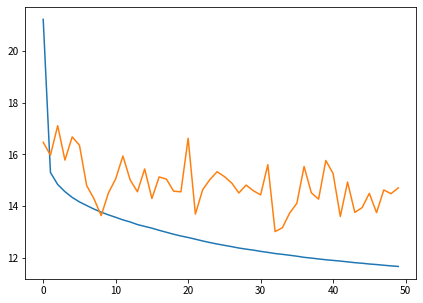

In [12]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(range(len(trainer.train_losses)), trainer.train_losses)
ax.plot(range(len(trainer.val_losses)), trainer.val_losses)
plt.show()

In [ ]:
print(trainer.validate(train_loader))
print(trainer.validate(val_loader))

## 予測結果

In [ ]:
start_date = pd.Timestamp('2022/5/1') - dt.timedelta(minutes=15) * time_step
end_date = pd.Timestamp('2022/5/9') - dt.timedelta(minutes=15)

In [ ]:
S = sec_table.shape[0]
T = int((end_date - start_date).total_seconds() // (60 * 15))
D = len(feature_col)

X_test = torch.empty((S, T, D), dtype=torch.float32)
y_test = torch.empty((S, T, 1), dtype=torch.float32)

for sec_id, (s_name, e_name, *_) in sec_table.iterrows():
    query = f'start_name == "{s_name}" & end_name == "{e_name}"'
    df_sec = df_all.query(f'start_name == "{s_name}" & end_name == "{e_name}"')
    df_sec = df_sec[(df_sec['datetime'] >= start_date) & (df_sec['datetime'] < end_date)]
    
    data = df_sec.loc[:, feature_col].values
    target = df_sec.loc[:, target_col].values
    
    X_test[sec_id] = torch.from_numpy(data)
    y_test[sec_id, :, 0] = torch.from_numpy(target)
    
X_test = scaler.transform(X_test)

dataset_test = STDataset(X_test, y_test, time_step=time_step, prediction_horizon=prediction_horizon)

In [ ]:
data = dataset_test[:][0].to(device=device)

with torch.no_grad():
    pred = model(data)

pred = pred.view(S, -1).to(device='cpu')
target = dataset_test[:][1].view(S, -1).to(device='cpu')

plot_sections = [27, 36]
fig, axes = plt.subplots(len(plot_sections), 1, figsize=(15, 7))
for i, sec_id in enumerate(plot_sections):
    axes[i].plot(target[sec_id], label='true')    
    axes[i].plot(pred[sec_id], label='pred')
    
    title = f'{sec_table.loc[sec_id, "start_name"]} ~ {sec_table.loc[sec_id, "end_name"]}'
    axes[i].set_title(title)

In [ ]:
tmp_train = df_test[(df_test['start_name'] == '鶴ヶ島') & (df_test['direction'] == 1)]
tmp_train = tmp_train.loc[:, key_col + features]

# 時系列長
N_period = tmp_train.drop_duplicates("datetime").shape[0]
# 区間数
N_sec = tmp_train.drop_duplicates(["start_name", "end_name"]).shape[0]
# 特徴量数
D = len(features)

tmp_train_value = tmp_train[features].values.reshape(1, N_period, D)
tmp_train_norm = (tmp_train_value - X_mean) / X_std

In [ ]:
tmp_X = []

for i in range(N_sec):
    for t in range(time_step, N_period - 24):
        time_pred = t + 24
        time_input = (t - time_step, t + time_step + 1)
        x_ = tmp_train_norm[i, time_input[0] : time_input[1]]
        tmp_X.append(x_)

tmp_X = torch.from_numpy(np.array(tmp_X, dtype=np.float32))

In [ ]:
tmp_pred = model(tmp_X.to(device=device))

In [ ]:
ys = np.arange(time_step, N_period - 24) + 24
tmp_y = tmp_train.iloc[ys, -1].values.reshape(-1, 1)
tmp_y = torch.from_numpy(tmp_y).to(device=device)

In [ ]:
tmp_y[-10:]

In [ ]:
tmp_pred[-10:]

In [ ]:
with torch.no_grad():
    i = 0
    for data, target in dataset_train:
        if i >= 10:
            break
        i += 1
        print(f'------- {i} -------')
        out = model(data.to(device=device))
        print(target)
        print(out)
        print(torch.sqrt(nn.functional.mse_loss(out, target.to(device=device))).item())
        print()

In [ ]:
n_epochs = 3000
in_dim = X_train.shape[-1]
hid_dim = 100
out_dim = 1
num_layers = 1

model = Net(in_dim, hid_dim, out_dim, num_layers).to(device=device)
optimizer = optim.Adam(model.parameters())

loss_fn = nn.MSELoss()

losses = []

for epoch in range(n_epochs):
    total_loss = 0
    for data, target in train_loader:
        data = data.to(device=device)
        target = target.unsqueeze(1).to(device=device)
        
        out = model(data)
        loss = loss_fn(out, target)
        total_loss += loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    losses.append(total_loss)

    if epoch < 3 or (epoch + 1) % 100 == 0:
        print(f'{dt.datetime.now()} | Epoch {epoch+1} | Loss: {loss}')